In [1]:
import sys
sys.path.append('../../PI_GP_regressor') 

from main_class import PhysicsInformedGP_regressor
from kernels.kernel_heat_equation import gram_Matrix_jax,k_ff_jax, k_fu_jax, k_uf_jax, k_uu_jax
import numpy as np
import jax 

 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:914: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:926: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:1003: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:1015: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


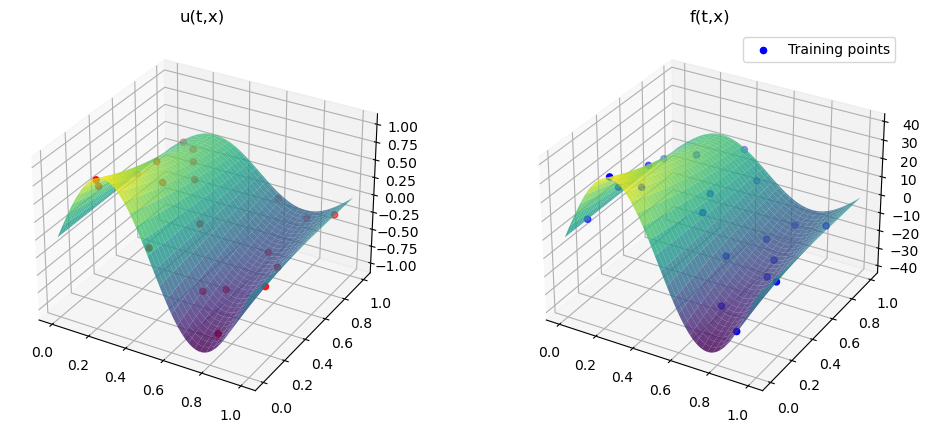

In [2]:
# first we put the kernel parts into a list
kernel_list = [gram_Matrix_jax, k_uu_jax, k_uf_jax, k_fu_jax, k_ff_jax]
#then we define the parameters for the kernel
hyperparameters = ["l_x", "sigma_f","l_t", "alpha"]
#now we can define our model. The model needs the kernel list and the hyperparameters, aswell as the timedependence
model_heat_equation = PhysicsInformedGP_regressor(kernel_list,timedependence=True, params=hyperparameters,Dimensions=2)
model_heat_equation.set_name_kernel("Wave_equation")
#now we create the training data and a validation set
n_training_points = 20
noise = [1e-8,1e-8]
model_heat_equation.set_training_data("heat_data_paper.csv",n_training_points, noise,[5,12])

n_validation_points = 1000  #for calculating the MSE
model_heat_equation.set_validation_data(n_validation_points)
model_heat_equation.plot_raw_data(True,False)

Now we can train the model. We can choose different methods for the training.   
  -CG: conjugate gradient --- fast but often not very accurate    
  -TNC: truncated Newton --- slower but more accurate     
  -L-BFGS-B: limited memory BFGS --- fast and accurate (not always for some reason)   

generally TNC is the best choice

In [3]:
#for the training we first need to define the initial parameters for the restarts
model_heat_equation.jitter = 1e-6
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-1.3,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lx
    theta_initial[1] = rng.uniform(0, 1, 1)               #sigma_f
    theta_initial[2] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lt
    theta_initial[3] = rng.uniform(0, 10, 1)               #c
    return theta_initial

n_restarts = 500; n_threads = 10
opt_params_dict = {'theta_initial': get_initial_values,   #needed for all optimization methods
                    'bounds': ((1e-2, None), (1e-5, None), (1e-3, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                    'gtol': 1e-6}
model_heat_equation.train("TNC",n_restarts, n_threads,opt_params_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:18<00:00,  6.37it/s]


     fun: -2.982633590698242
     jac: array([-10.625   ,  -5.953125,   4.623047,  10.953125], dtype=float32)
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 69
     nit: 8
  status: 2
 success: True
       x: array([0.31456867, 0.93943729, 1.22464797, 0.99977528])


         lx   sigma_f        lt         c  function_values
0  0.206237  0.404859  1.210150  1.000257         9.703850
1  0.529816  0.723155  0.279533  6.433228     45428.570312
2  1.108899  0.593699  0.281551  7.492368    257138.546875
3  0.329293  0.926687  0.335223  0.985885        20.011131
4  0.489187  0.512850  0.272926  1.754671      7160.899902


 /var/folders/5m/h4l2_hmn45j_y5q22rrhkpnr0000gn/T/ipykernel_11049/1072955217.py:20: RuntimeWarning:invalid value encountered in log


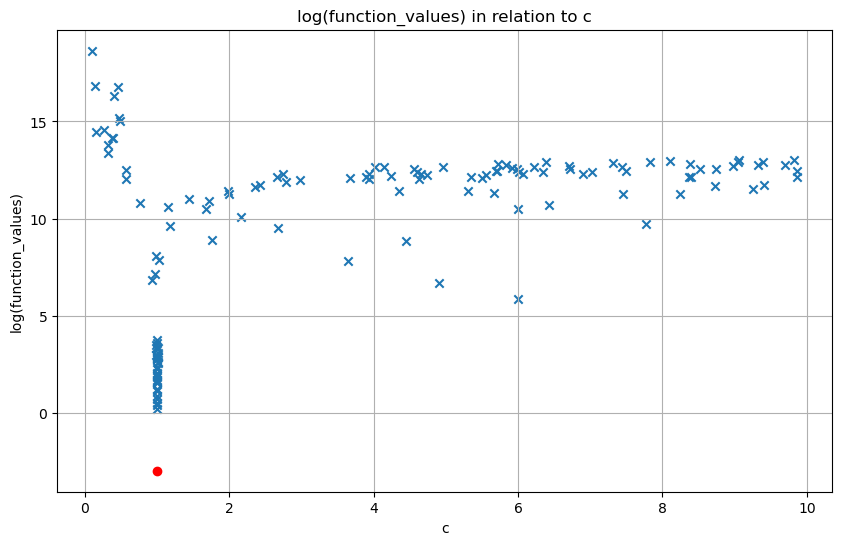

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


results = model_heat_equation.results_list

theta_list = np.array([thet.x for thet in results])
function_values = np.array([thet.fun for thet in results])
df_results = pd.DataFrame(theta_list, columns=["lx", "sigma_f","lt", "c"])
df_results["function_values"] = function_values
print(df_results.head())


df_results = df_results.sort_values(by=["c"])
loc_minimum = np.argmin(df_results["function_values"])
#remove the row with the maximum function value

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(np.array(df_results["c"]), np.log(np.array(df_results["function_values"])), marker = "x")
ax.scatter(df_results.iloc[loc_minimum,3],(df_results.iloc[loc_minimum,4])  ,label = f"minimum with c = {df_results.iloc[loc_minimum, 3]:.5f} \ny = {df_results.iloc[loc_minimum, 4]:.5f}", color = "red")
ax.set_xlabel("c")
ax.set_ylabel("log(function_values)")
ax.set_title("log(function_values) in relation to c")
ax.grid(True)
#ax.legend()

# # want a zoomed in plot
# axins = ax.inset_axes([0.6, 0.1, 0.4, 0.4])
# axins.scatter(np.array(df_results["c"]), np.array(df_results["function_values"]))
# axins.scatter(df_results.iloc[loc_minimum,3],(df_results.iloc[loc_minimum,4])  ,label = f"minimum with c = {df_results.iloc[loc_minimum, 3]}", color = "red")
# axins.set_xlim(0, 2)
# axins.set_ylim(-1, 6)
# axins.grid(True)
# axins.set_xlabel("c")
# axins.set_ylabel("function_values")
# axins.set_yscale('linear') # set y-axis to linear scale
# ax.indicate_inset_zoom(axins, edgecolor="red", alpha=0.6)


In [26]:
#i want to look at the 10 best results
df_results = df_results.sort_values(by=["function_values"])
df_best_results = df_results.iloc[:15,:]
display(df_best_results)


,lx,sigma_f,lt,c,function_values
23,0.314569,0.939437,1.224648,0.999775,-2.982634
49,0.332770,0.792383,0.977300,1.000130,-2.359007
27,0.306712,0.835264,0.993350,0.999496,-1.941168
79,0.353703,0.900303,0.758491,1.000929,-1.109652
16,0.332271,0.694733,0.931597,1.001269,-0.707930
125,0.333184,0.642084,0.677742,1.001023,1.221771
80,0.316807,0.490818,0.876743,1.001267,1.503241
91,0.356834,0.676203,0.727617,1.002769,1.691645
58,0.339185,0.919941,0.621599,1.001235,2.008230
88,0.300568,0.448529,0.745239,1.001323,2.420984


In [126]:
#model_heat_equation.set_params([0.38805983, 0.1, 1.23973298, 0.99992222])
#model_heat_equation.set_params([0.32702307, 1.22095426, 0.73154797, 0.8015203 ])
model_heat_equation.set_axis_labels("x","t")
model_heat_equation.jitter = 1e-6
n_test_points = 100
x_star, t_star = np.meshgrid(np.linspace(0, 1, n_test_points), np.linspace(0, 1, n_test_points))
X_star = np.hstack((x_star.reshape(-1, 1), t_star.reshape(-1, 1)))
model_heat_equation.predict_model(X_star)
model_heat_equation.error()
print(model_heat_equation)

-----------------------------------------------
GP with kernel: 
Training data: (20, 2)
Training targets: (40, 1)
Hyperparameters: {'l_x': 0.3611904606196721, 'sigma_f': 1.2844339584126399, 'l_t': 1.0080411746271731, 'alpha': 0.9997691508507037}
Log marginal likelihood: -4.386297225952148
Mean squared error: {'u': 3.5967127587355208e-06, 'f': 0.025441311299800873}
Relative l2 error: {'u': 0.004092987466248074, 'f': 0.00894623287562946}
-----------------------------------------------



 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:1142: RuntimeWarning:invalid value encountered in sqrt
 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:1151: RuntimeWarning:invalid value encountered in sqrt


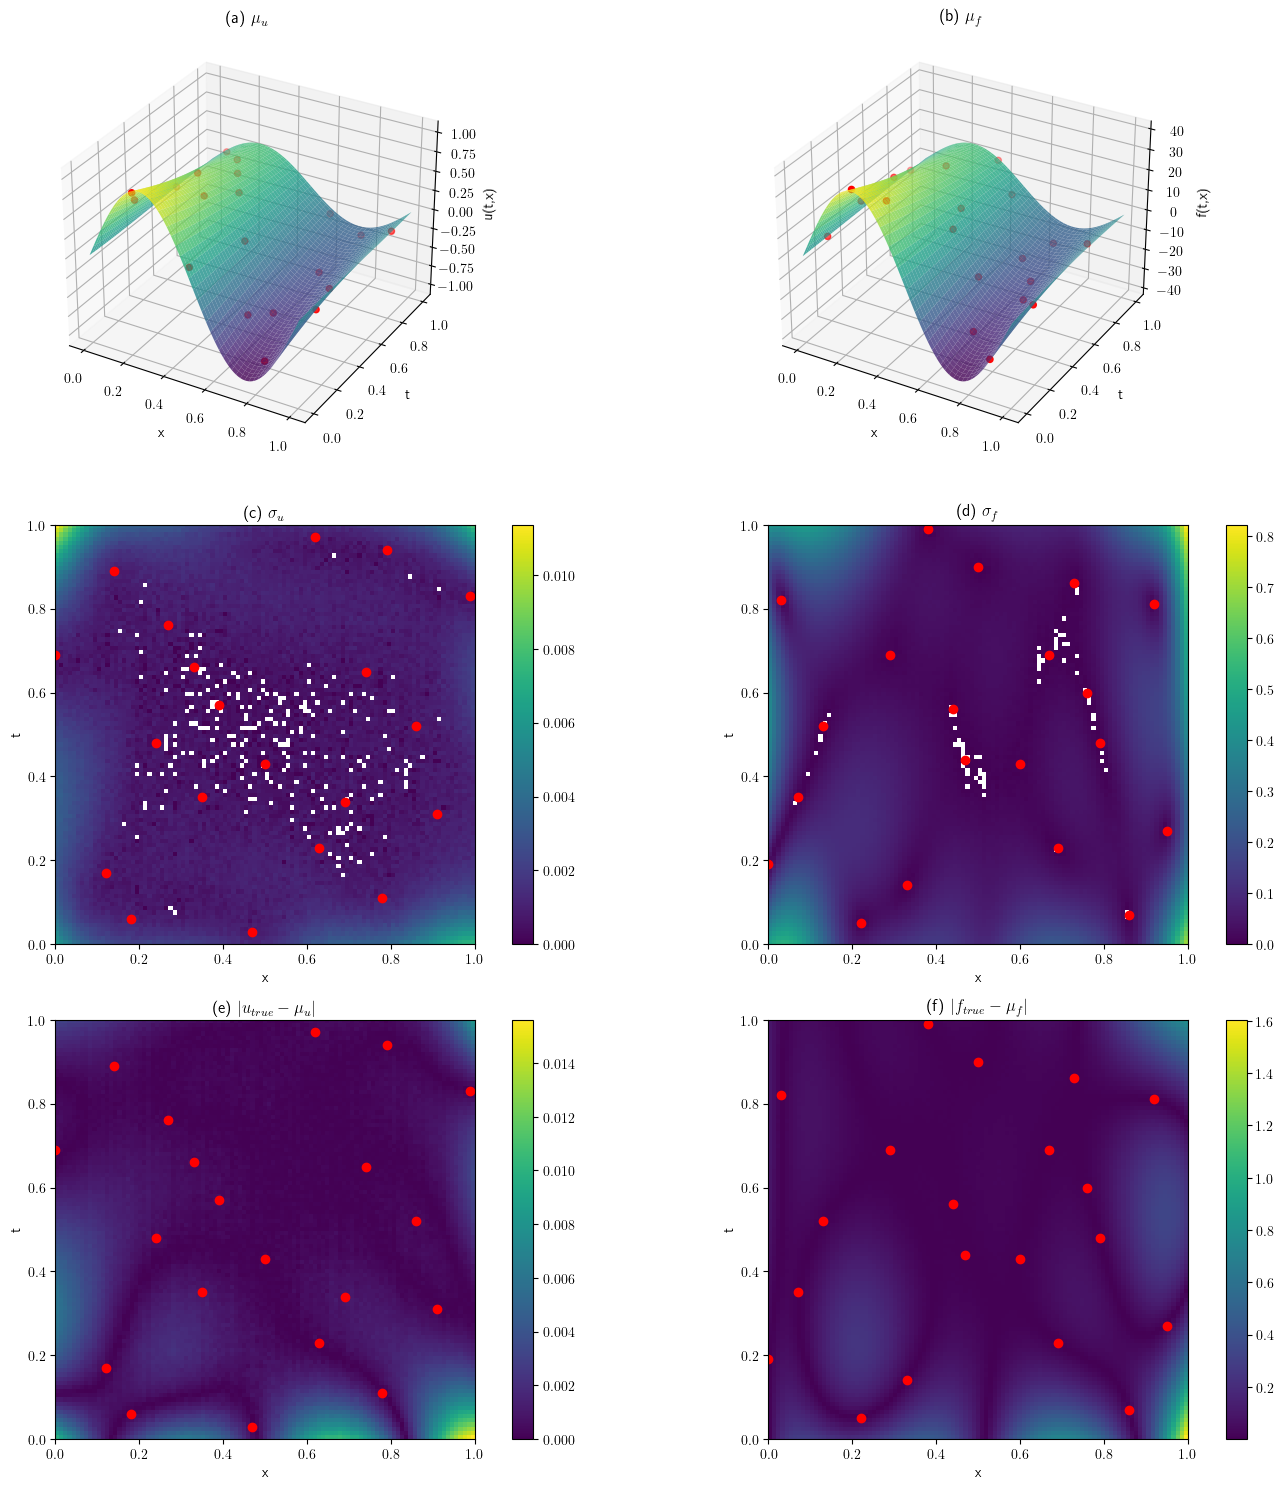

In [128]:
model_heat_equation.plot_merged_2d_plots(X_star,"merged_plots.png")

We can now do the same with the GPy library with a non modified kernel(we just use the RBF kernel with ARD)

In [ ]:
model_heat_equation.use_GPy(X_star,"GPy_predictive_mean",False)

In [ ]:
model_heat_equation.plot_difference_GPy("difference GPy ", "GPy_difference.png")
model_heat_equation.plot_variance_GPy("predictive variance GPy ", "GPy_variance.png")